In [82]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RandomizedLogisticRegression
from sklearn.cross_validation import StratifiedKFold, train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load files
train = pd.read_csv('../data/train2016.csv')
test  = pd.read_csv('../data/train2016.csv')
sub   = pd.read_csv('../data/sampleSubmission2016.csv')

** t-sne clustering to see if there are any obviious clusters **

In [3]:
# for tsne to work first
# 1. Impute missing values
# 2. Encode categorical values

def fill_missing_values(df):
    df = df.copy()
    
    for cat in df.columns:
        if df[cat].isnull().any():
            if df[cat].dtype == 'object':
                df[cat] = df[cat].fillna('-999')
            else:
                df[cat] = df[cat].fillna(-9999)
    return df

def encode_cat_features(df):
    df = df.copy()
    
    for cat in df.columns:
        if df[cat].dtype == 'object':
            lbl = LabelEncoder()
            
            lbl.fit(df[cat])
            df[cat] = lbl.transform(df[cat])
    
    return df

In [10]:
train_ = fill_missing_values(train)
train_ = encode_cat_features(train_)

In [12]:
DROP_FEATURES = ['USER_ID', 'PARTY']

features = [col for col in train_.columns if col not in DROP_FEATURES]

In [14]:
print('Shape of the dataset ', train_[features].shape)

Shape of the dataset  (5568, 107)


#### Visualize this high dimensional data

```
Perplexity: How to balance attention between local and global aspects of your data ?
The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.
```

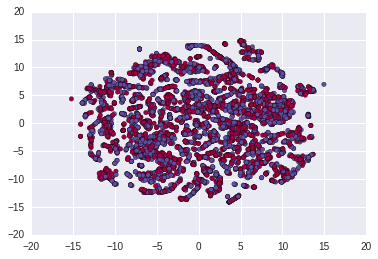

In [23]:
tsne = TSNE(n_components=2, perplexity=5.0, random_state=12386)
Y = tsne.fit_transform(train_[features])

plt.scatter(Y[:, 0], Y[:, 1], c=(train.Party), cmap=plt.cm.Spectral);

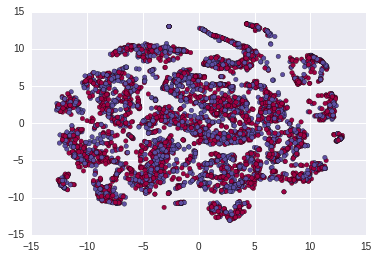

In [19]:
tsne = TSNE(n_components=2, perplexity=15.0, random_state=12386)
Y = tsne.fit_transform(train_[features])

plt.scatter(Y[:, 0], Y[:, 1], c=(train.Party), cmap=plt.cm.Spectral);

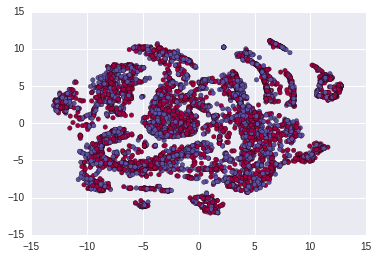

In [24]:
tsne = TSNE(n_components=2, perplexity=30.0, random_state=12386)
Y = tsne.fit_transform(train_[features])

plt.scatter(Y[:, 0], Y[:, 1], c=(train.Party), cmap=plt.cm.Spectral);

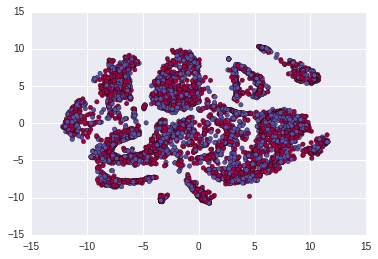

In [25]:
tsne = TSNE(n_components=2, perplexity=50.0, random_state=12386)
Y = tsne.fit_transform(train_[features])

plt.scatter(Y[:, 0], Y[:, 1], c=(train.Party), cmap=plt.cm.Spectral);

```
Create variable called Age which is the difference of YOB from 2016 and then label them into different categories.
```

In [4]:
def create_age(yob):
    if yob != -9999:
        return 2016 - yob
    else:
        return -9999

def create_age_mapping(age):
    if age < 17:
        return 0
    elif age >= 18 and age < 25:
        return 1
    elif age >= 25 and age < 35:
        return 2
    elif age >= 35 and age < 50:
        return 3
    elif age >= 50 and age < 65:
        return 4
    elif age >= 65:
        return 5
    else:
        return -9999

In [ ]:
train_['Age'] = train.YOB.map(create_age)
train_['Age_Mapping'] = train_.Age.map(create_age_mapping)

In [41]:
train_.Age_Mapping.value_counts()

 3       1451
 1       1381
 2       1229
 4        708
 0        381
 5        328
-9999      90
Name: Age_Mapping, dtype: int64

In [43]:
pd.crosstab(train.Age_Mapping, train.Party, margins=True)

Party,0,1,All
Age_Mapping,,,
-9999,41,49,90
0,196,185,381
1,731,650,1381
2,657,572,1229
3,770,681,1451
4,367,341,708
5,189,139,328
All,2951,2617,5568


In [5]:
# concat train and test datasets
data = pd.concat((train, test))

data = fill_missing_values(data)
data = encode_cat_features(data)

In [6]:
# create two new features
data['Age'] = data.YOB.map(create_age)
data['Age_Mapping'] = data.Age.map(create_age_mapping)

In [56]:
train.columns

Index(['USER_ID', 'YOB', 'Gender', 'Income', 'HouseholdStatus',
       'EducationLevel', 'Party', 'Q124742', 'Q124122', 'Q123464',
       ...
       'Q100010', 'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059',
       'Q98078', 'Q98197', 'Q96024'],
      dtype='object', length=108)

In [83]:
# consider only this feature age mapping and see if it is of any importance
mask = (data.Party.notnull())

# features = ['Age_Mapping', 'Gender', 'HouseholdStatus',\
#             'EducationLevel']\
features = data.columns.drop(['USER_ID', 'Party'])

X = data.loc[mask, features]
y = data.Party

Xtest = data.loc[~mask, features]

** Split into training and test sets **

In [84]:
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=12386)

In [85]:
est = LogisticRegression()
skf = StratifiedKFold(ytr, n_folds=5, random_state=123)

cv_scores = cross_val_score(est, Xtr, ytr, scoring='accuracy', cv=skf, n_jobs=-1)

In [86]:
print('Mean cv score: %f and std: %f'%(cv_scores.mean(), cv_scores.std()))

Mean cv score: 0.606084 and std: 0.007556


** Check score on the holdout set **

In [87]:
est.fit(Xtr, ytr)
yhat = est.predict(Xte)

print('Accuracy on the hold out set: %f'%(accuracy_score(yte, yhat)))

Accuracy on the hold out set: 0.610413


** Confidence Intervals **

```
One way to get confidence intervals is to bootstrap your data, say, B times and fit logistic regression models mi to the dataset Bi for i=1,2,...,Bi=1,2,...,B. This gives you a distribution for the parameters you are estimating, from which you can find the confidence intervals.
```

In [88]:
def get_confidence_intervals(est, X, y):
    skf = StratifiedKFold(y, n_folds=5, random_state=133)
    
    coefficients = []
    
    for index, (itr, ite) in enumerate(skf):
        xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        est.fit(xtr, ytr)
        coef_ = est.coef_
        
        coefficients.append(coef_)
    
    return np.average(coefficients, axis=0), np.std(coefficients, axis=0)

In [89]:
estimated_coefficients, estimated_deviation = get_confidence_intervals(est, Xtr, ytr)

In [90]:
print('Estimated Coefficients: %s'%(estimated_coefficients))
print('Estimated deviation: %s'%(estimated_deviation))

Estimated Coefficients: [[ -2.51351817e-04   1.73332574e-01   2.95421913e-02   1.32233877e-02
   -1.82944831e-02   1.92307272e-02  -8.30060544e-02   3.27833552e-02
    7.35806764e-02   1.05390260e-02   7.65688988e-02  -4.89879214e-02
    1.46536630e-01  -1.22267305e-01  -8.01785711e-02  -2.12492429e-02
   -2.07778353e-02  -1.85725405e-01   9.70310858e-02   1.32256316e-01
    3.02566719e-02  -6.64795931e-02   7.94923914e-02   5.42069897e-02
   -8.02961664e-02   1.44332970e-02  -1.77497081e-02   6.36312340e-02
    9.89228610e-03  -6.72258529e-02   5.31580964e-02   2.62723788e-02
    9.65140750e-03   3.19433549e-02   1.44833732e-01  -9.63813269e-02
   -9.54152053e-02   9.67592488e-02  -4.58517179e-02   1.14002529e-02
   -1.22404241e-01  -5.77955355e-02  -5.30912337e-02   4.12525670e-01
    6.67595408e-02  -7.44757630e-02  -3.74725289e-03  -4.38226867e-02
   -3.96492050e-02  -9.21749324e-02   1.73098503e-02  -4.74070355e-02
   -1.73668572e-04  -9.75510113e-02   2.73340860e-02   2.49204299e

** Feature Selection using Randomized Logistic Regression Model **

In [100]:
randomized_logistic = RandomizedLogisticRegression(C=10.)
randomized_logistic.fit_transform(Xtr, ytr)

array([[  1.96400000e+03,   1.00000000e+00,   3.00000000e+00, ...,
          2.00000000e+00,   5.20000000e+01,   4.00000000e+00],
       [  1.98700000e+03,   2.00000000e+00,   6.00000000e+00, ...,
          0.00000000e+00,   2.90000000e+01,   2.00000000e+00],
       [  1.99800000e+03,   1.00000000e+00,   6.00000000e+00, ...,
          0.00000000e+00,   1.80000000e+01,   1.00000000e+00],
       ..., 
       [  1.97800000e+03,   0.00000000e+00,   4.00000000e+00, ...,
          2.00000000e+00,   3.80000000e+01,   3.00000000e+00],
       [  1.98800000e+03,   2.00000000e+00,   2.00000000e+00, ...,
          1.00000000e+00,   2.80000000e+01,   2.00000000e+00],
       [  1.96300000e+03,   1.00000000e+00,   5.00000000e+00, ...,
          0.00000000e+00,   5.30000000e+01,   4.00000000e+00]])

In [101]:
selected_features = randomized_logistic.get_support()

In [102]:
print('Selected Features are :\n %s'%(features[selected_features].tolist()))

Selected Features are :
 ['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Q124742', 'Q124122', 'Q123464', 'Q123621', 'Q122769', 'Q122770', 'Q122771', 'Q122120', 'Q121699', 'Q121700', 'Q120978', 'Q121011', 'Q120379', 'Q120650', 'Q120472', 'Q120194', 'Q120012', 'Q120014', 'Q119334', 'Q119851', 'Q119650', 'Q118892', 'Q118117', 'Q118232', 'Q118233', 'Q118237', 'Q117186', 'Q117193', 'Q116797', 'Q116881', 'Q116953', 'Q116601', 'Q116441', 'Q116448', 'Q116197', 'Q115602', 'Q115777', 'Q115610', 'Q115611', 'Q115899', 'Q115390', 'Q114961', 'Q114748', 'Q115195', 'Q114517', 'Q114386', 'Q113992', 'Q114152', 'Q113583', 'Q113584', 'Q113181', 'Q112478', 'Q112512', 'Q112270', 'Q111848', 'Q111580', 'Q111220', 'Q110740', 'Q109367', 'Q108950', 'Q109244', 'Q108855', 'Q108617', 'Q108856', 'Q108754', 'Q108342', 'Q108343', 'Q107869', 'Q107491', 'Q106993', 'Q106997', 'Q106272', 'Q106388', 'Q106389', 'Q106042', 'Q105840', 'Q105655', 'Q104996', 'Q103293', 'Q102906', 'Q102674', 'Q102687', 'Q102289

In [103]:
est.fit(Xtr[features[selected_features]], ytr)
yhat = est.predict(Xte[features[selected_features]])
print('Accuracy after feature selection: %f'%(accuracy_score(yte, yhat)))

Accuracy after feature selection: 0.611759
